In [27]:
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd 
import pymc as pm
import arviz as az
import statistics as stats
import matplotlib.pyplot as plt
import os,sys

In [28]:
# getting the name of the directory
# where the this file is present.
# current = os.path.dirname(os.path.realpath(__file__))
current = os.path.dirname(os.getcwd())
 
# Getting the parent directory name
# where the current directory is present.
parent = os.path.dirname(os.path.dirname(current))
#/Users/pizarror/IDM

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

from IDM_Model.src import model_functions as mf

In [29]:
def read_load_data(fn='/tmp',alpha0=1.0):
    df = pd.read_csv(fn)
    # remove practice trials
    df = df.loc[df['cdd_trial_type']=='task']
    # insert probability as choice into data
    cols = ['cdd_trial_resp.corr','cdd_immed_amt','cdd_delay_amt','cdd_immed_wait','cdd_delay_wait','alpha']
    # also returns percent_reward which we do not need here
    data = mf.get_data(df,cols,alpha_hat=alpha0)[0]
    return data

In [30]:
CDD_fn = '/Volumes/UCDN/datasets/IDM/utility/23_IDM_0130/cdd/23_IDM_0130_cdd.csv'

data = read_load_data(fn=CDD_fn,alpha0=1.0)

print(data)


    cdd_trial_resp.corr  cdd_immed_amt  cdd_delay_amt  cdd_immed_wait   
3                   0.0           10.0           29.0             0.0  \
4                   0.0           10.0           65.0             0.0   
5                   0.0            2.0           11.0             0.0   
6                   0.0           10.0            8.0             0.0   
7                   0.0            2.0           22.0             0.0   
..                  ...            ...            ...             ...   
94                  0.0           10.0           65.0             0.0   
95                  0.0           20.0           65.0             0.0   
96                  1.0            2.0           42.0             0.0   
97                  0.0           10.0           16.0             0.0   
98                  0.0           20.0           51.0             0.0   

    cdd_delay_wait  alpha  
3             60.0    1.0  
4             59.0    1.0  
5             60.0    1.0  
6          

Import Data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, b]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 34 seconds.


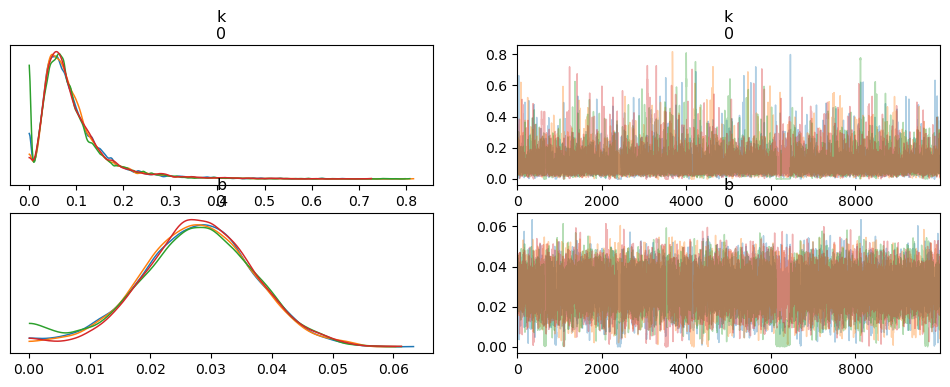

In [31]:
# This is a simple model. This is not good for our case. It will just get one k and one b for each session, but it won't incorporate everyone's data. Returns wonky values as far as I remember.


SSA = data['cdd_immed_amt'].values
SSD = data['cdd_immed_wait'].values
LLA = data['cdd_delay_amt'].values
LLD = data['cdd_delay_wait'].values
y_simple = data['cdd_trial_resp.corr'].values

with pm.Model() as model_simple:

    k = pm.Beta('k',mu=0.01,sigma=0.05,shape=1)#np.size(SSA)) #mu=0.1, mu=0.07,sd=0.1 05
    b = pm.HalfNormal('b',sigma=0.01,shape=1)#np.size(SSA)) #mu=0.1, mu=0.005,sd=0.01 mu=0,
    
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-b * ( LLA/(1+(k*LLD)) - SSA/(1+(k*SSD)) ))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    trace_simple = pm.sample(10000, tune=10000, target_accept=0.99)


# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
az.plot_trace(trace_simple, var_names=["k","b"],compact=False)
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
Summary= az.summary(trace_simple,round_to=10)
# Again, call it what you want (yeah - call it what you want tooooo)
Summary.to_csv("Summary_from_simple_trace.csv")

In [7]:
##------------------------------------------------------------------##
##                             Import                               ##
##  I did a pretty in-depth walkthrough of the BHM code in the      ##
##  methods document, so I won't go into as much detail here about  ##
##  the overall scheme. Instead, I'll be annotating lines to        ##
##  clarify what they specifically do. I'll also put brief          ##
##  explanatory bits at the top as necessary.                       ##
##------------------------------------------------------------------##

# For parameter recovery: "Full Square\FAKE RANDOMIZED Full Subjective Value Table Full Square With Generated Choices.csv"
# This can intake any data in a form similar to the Full Subjective Value Table
data = genfromtxt("Full Subjective Value Table.csv", delimiter=',', dtype=str)

# Column titles: Trial Number	Stimulus Time	Response Time	SS amount	LL amount	SS delay	LL delay	Response	SS SV	LL SV	k	beta	ID	Day	Date	Time	LL	AIC	BIC	r2	correct percent
IDs = np.array(data[1:,12])
Days = np.array(data[1:,13])
Dates = np.array(data[1:,14])
Times = np.array(data[1:,15])

# Each participant session can be uniquely identified by a combination of ID, day, date, and time. This concatenates them all.
Identifiers = np.array([i + j + k + l for i, j, k, l in zip(IDs, Days, Dates, Times)])

# Note: these are all brought in as strings from genfromtext. It is critical to convert them to floats.
SSAmount = np.array(data[1:,3], dtype=float)
SSDelay = np.array(data[1:,5], dtype=float)
LLAmount = np.array(data[1:,4], dtype=float)
LLDelay = np.array(data[1:,6], dtype=float)
Choices = np.array(data[1:,7], dtype=int)

# These are the betas and kappas from MLE. These lines can be used to compare MLE to BHM.
Betas = np.array(data[1:,11], dtype=float)
Kappas = np.array(data[1:,10], dtype=float)

# This will select only the non-catch trials.
boolselector = (SSAmount<1000)*(LLDelay>0)

IDs = IDs[boolselector]
Days = Days[boolselector]
Dates = Dates[boolselector]
Times = Times[boolselector]
Identifiers = Identifiers[boolselector]
SSAmount = SSAmount[boolselector]
SSDelay = SSDelay[boolselector]
LLAmount = LLAmount[boolselector]
LLDelay = LLDelay[boolselector]
Choices = Choices[boolselector]
Betas = Betas[boolselector]
Kappas = Kappas[boolselector]


Create Groups

In [4]:
# I put a full explanation of the idea behind this groups array in the methods document. I'll annotate the code here, but for information on the goal and general idea behind this, check out that document.

# Array equivalent in size to IDs (arbitrary choice - could be Betas or LLAmount or anything; all the same size). Fill with ridiculous number for now so it'll throw errors later if the groups array isn't populated right.
groups = np.full(len(IDs),100000)
alreadycoded = []
indextocount = 0

# Fill the groups array starting with 0. Each identifier combo (participant session) will have one group number, and each individual choice in that session will have that group number.
for identifier in Identifiers:
    if identifier not in alreadycoded:
        groups[Identifiers==identifier] = indextocount
        indextocount = indextocount + 1
        alreadycoded.append(identifier)

Run Simpler Hierarchical Model

In [ ]:
y_simple = Choices

# Future directions: might consider a transformation of amounts and delays like the following:
#SSA_adj = (SSA - np.mean(SSA))/100
#SSD_adj = (SSD - np.mean(SSD))/100
#LLA_adj = (LLA - np.mean(LLA))/100
#LLD_adj = (LLD - np.mean(LLD))/100


with pm.Model() as model_fancy:

    # Hyperparameters for k
    mu_k = pm.Beta('mu_k',mu=0.01,sd=0.05)
    sd_k = pm.Beta('sd_k',mu=0.05,sd=0.05)

    k = pm.Beta('k',mu=mu_k,sd=sd_k, shape=np.size(np.unique(groups))) #mu=0.1, mu=0.07,sd=0.1 05
    b = pm.HalfNormal('b',sd=0.01, shape=np.size(np.unique(groups))) #mu=0.1, mu=0.005,sd=0.01 mu=0,      # the more complex model does hyperparameters here too

    # Lots of information about this in the explanation document
    # Deterministic, by the way, indicates that we're not doing a distribution really. We're just doing a calculation.
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(b[groups]*(SSAmount/(1+(k[groups]*SSDelay))-LLAmount/(1+(k[groups]*LLDelay))))))

    # Could do observed=Choices here - it would be the same.
    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    # Could increase target_accept if this doesn't run well (shouldn't be necessary). Reduce steps if you want it to go fast but be less good (ok for testing; note though that it'll still be hours probably)
    trace_fancy = pm.sample(10000, tune=10000, target_accept=0.99) #,target_accept=0.9995  *********COMMENT/UNCOMMENT TO RUN/NOT RUN*********

# Call the trace whatever you like. This just saves it. You don't want to run a whole model and then accidentally x-out your window or refresh or something and lose it all!
pm.save_trace(trace_fancy, 'Trace from data generated by tiling smaller range.trace')
# This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
Summary= az.summary(trace_fancy,round_to=10)
# Again, call it what you want (yeah - call it what you want tooooo)
Summary.to_csv("Summary from data generated by tiling smaller range.csv")

Run Double Hierarchical Parameter Estimation

In [6]:
y_simple = Choices

# By the way, the names here are all arbitrary. "model_diff_dists_log," "mu_k," "logb" - these are all made up and aren't meaningful code-wise
with pm.Model() as model_diff_dists_log:

    mu_k = pm.Beta('mu_k',mu=0.01,sd=0.05)
    sd_k = pm.Beta('sd_k',mu=0.05,sd=0.05)

    # Hyperparameters for the truncated normal distribution. 
    mu_b = pm.Normal('mu_b',mu=4.577, sd=1)
    sd_b = pm.Exponential('sd_b',10)

    k = pm.Beta('k',mu=mu_k,sd=sd_k, shape=np.size(np.unique(groups)))

    logb = pm.TruncatedNormal('logb',mu=mu_b,sd=sd_b, lower=(-math.log(8.4)), upper=(-math.log(10**-8)),shape=np.size(np.unique(groups)))

    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp((math.e**-logb[groups])*(SSAmount/(1+(k[groups]*SSDelay))-LLAmount/(1+(k[groups]*LLDelay))))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    trace_diff_dists_log_full = pm.sample(10000, tune=10000, target_accept=0.99) #,target_accept=0.9995  *********UNCOMMENT TO RUN*********

pm.save_trace(trace_diff_dists_log_full, 'Trace 7_27 dists norm full real data.trace')
Summary_norm= az.summary(trace_diff_dists_log_full,round_to=10)
Summary_norm.to_csv("Summary 7_27 real data norm beta dist.csv")

c:\Users\benlg\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logb, k, sd_b, mu_b, sd_k, mu_k]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 25893 seconds.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\benlg\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Create Summary Table and Save Trace

In [ ]:
# This is duplicated above. Unnecessary to run it again. I originally had them separate.

pm.save_trace(trace_fancy, 'Trace from data generated by tiling.trace')
Summary= az.summary(trace_fancy,round_to=10)
Summary.to_csv("Summary from data generated by tiling.csv")

Load Trace and Table

In [ ]:
# Change names to the trace that you want to load. You might want to do this early on if you're using the models that I already ran. I'll include a folder of traces.
with model_fancy:
    trace_fancy = pm.load_trace('Fancytrace2.trace')
Summary= az.summary(trace_fancy,round_to=10)

# "Fancytrace3.trace" is the best simple run. "Trace 7_27 dists norm full real data.trace" is the most recent double hierarchical run.

Compare Accuracy

In [14]:
# The below accuracy comparison array code refers to "Summary". If you're using a different model, replace with whatever you've called the summary of that model.
Summary = Summary_norm

In [ ]:
# This code creates an accuracy comparison array between the MLE and BHM approaches. 

outarray = np.array(["ID","Day","oldK","newK","oldB","newB","oldAcc","newAcc", "oldBIC", "newBIC", "oldr2", "newr2","kdiff"])
for pick in range(np.size(np.unique(Identifiers))):
    boolpick = Identifiers==(np.unique(Identifiers)[pick])

    SSA = SSAmount[boolpick]
    SSD = SSDelay[boolpick]
    LLA = LLAmount[boolpick]
    LLD = LLDelay[boolpick]
    Cs = Choices[boolpick]

    oldK = Kappas[boolpick][1]
    oldB = Betas[boolpick][1]
    newK = Summary['mean'][4+pick]  # 4 when using the complex model; 2 otherwise    <IMPORTANT: Otherwise this will be wrong. Run tests to make sure that you're indexing the right values. Example: print(Summary_norm['mean'][120:])
    
    #Can just call this "newB" if you're using the simpler BHM.
    newLogB = Summary['mean'][4+pick+116]

    # Only use this with the new logb model. Otherwise it'll be totally wrong.
    newB = math.e**(-newLogB)

    kdiff = newK-oldK

    # Little bit of array shenanigans to find accuracy. Choices count as accurate when the LL SV is greater than SS SV and Choice = 1, or when LLSV<LSSSV & C=0. Count and divide by total, *100, gets percent.
    newKacc= 100*(np.sum(((LLA/(1+(newK*LLD)) > SSA/(1+(newK*SSD))) == Cs))/np.size(Cs))
    oldKacc= 100*(np.sum(((LLA/(1+(oldK*LLD)) > SSA/(1+(oldK*SSD))) == Cs))/np.size(Cs))

    # This analysis function is copied from the MLE code. See below. I made some prettiness changes in the MLE code that I haven't made here, but it runs the same.
    oldLL,oldLL0,oldAIC,oldBIC,oldr2,oldcorrect = analysis(Cs,SSA,SSD,LLA,LLD,1,oldK,oldB)
    newLL,newLL0,newAIC,newBIC,newr2,newcorrect = analysis(Cs,SSA,SSD,LLA,LLD,1,newK,newB)

    row = np.array((IDs[boolpick][1], Days[boolpick][1], oldK, newK, oldB, newB, oldKacc, newKacc, oldBIC, newBIC, oldr2, newr2, kdiff))
    
    outarray = np.vstack((outarray,row))


print(outarray[1:,1:])

# Make a row of averages and slap it on top of the existing array of values.
avesrow = np.average((outarray[1:,1:]).astype(float),0) #np.reshape( ,(1,))
outarray = np.vstack((outarray[0],np.hstack((np.array(["Averages"]),avesrow)),outarray[1:]))

pd.DataFrame(outarray).to_csv('Accuracy Comparison Array with Double Hierarchical Model.csv', header=False, index=False)
    

Functions from Non-Bayesian Approach

In [18]:
# Note: All of this is pretty much copied from the MLE code.

# naming conventions that I've kept for consistency with the original code - "v1" refers to SSAmount, and "v2" refers to LLAmount.


def analysis(choices,v1,d1,v2,d2,risk,given_k,beta):
    # Changed from other program: added LLfromGiven functionality right here
    given_beta = [beta,given_k]  #FYI: name conventions are wonky here. The pairing of b,k is referred to as "beta". We also call that stochasticity factor "beta". I think the latter is not quite proper, but I don't know.
    negLL = local_negLL(given_beta,choices,v1,d1,v2,d2,risk)
    
    # Unrestricted log-likelihood
    LL = -negLL

    # Restricted log-likelihood
    LL0 = np.sum((choices==1)*math.log(0.5) + (1-(choices==1))*math.log(0.5))

    # Akaike Information Criterion
    AIC = -2*LL + 2*2  #CHANGE TO len(results.x) IF USING A DIFFERENT MODEL (parameters != 2)

    # Bayesian information criterion
    BIC = -2*LL + 2*math.log(len(v1))  #len(results.x)

    #R squared
    r2 = 1 - LL/LL0

    #Percent accuracy
    k_for_accuracy = given_k
    beta_for_accuracy = [beta,k_for_accuracy]
    parray = np.array(choice_prob(v1,d1,v2,d2,beta_for_accuracy,risk))
    correct =sum((parray>=0.5)==choices)/len(v1)

    #print("k=",given_k)
    #print("LL",LL,"AIC",AIC,"BIC",BIC,"R2",r2,"correct",correct)
    return(LL,LL0,AIC,BIC,r2,correct)

def LLfromGiven(given_k, given_b, choices, v1, d1, v2, d2, risk):   #not currently in use
    given_beta = [given_b,given_k]
    negLL = local_negLL(given_beta,choices,v1,d1,v2,d2,risk)
    return negLL

def local_negLL(beta,choices_list,v1,d1,v2,d2,risk):

    ps = np.array(choice_prob(v1,d1,v2,d2,beta,risk))
    choices = np.array(choices_list)

    # Trap log(0)
    ps[ps==0] = 0.0001
    ps[ps==1] = 0.9999
    
    # Log-likelihood

    err = (choices==1)*np.log(ps) + ((choices==0))*np.log(1-ps)
    # Sum of -log-likelihood
    sumerr = -sum(err)
    return sumerr

def choice_prob(v1,d1,v2,d2,beta,risk):
    ps = []

    for n in range(len(v1)):
        #print(v1[n])
        SV_1 = discount(v1[n],d1[n],beta[1],risk)
        SV_2 = discount(v2[n],d2[n],beta[1],risk)
        try: 
            p = 1 / (1 + math.exp(beta[0]*(SV_1-SV_2)))
        except OverflowError:
            #print("beta:",beta[0],"k:",beta[1],"SV_1:",SV_1,"SV_2",SV_2,"imm val",v1[n],"imm delay",d1[n], "del val",v2[n],"del del",d2[n])
            p = 0
            #raise SystemExit(0)
            #break
        ps.append(p)
        
    return ps

def discount(v,d,kappa,risk):
    SV = (v**risk)/(1+kappa*d)
    return SV

Other Approaches

1. Fully Pooled Model

In [ ]:
# This is a fully pooled model. This is not good for our case. It will just get one k and one b for the whole population.

with pm.Model() as pooled_model:
    slope = pm.Beta('slope', 1, 5)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', ((LLA/(1+(slope/1000)*LLD))>=SSA/(1+(slope/1000)*SSD)), noise, observed=Cs)
    
    pooled_trace = pm.sample(return_inferencedata=True)

pm.summary(pooled_trace)

2. Super Simple Non-Hierarchical Model

In [ ]:
# This is a simple model. This is not good for our case. It will just get one k and one b for each session, but it won't incorporate everyone's data. Returns wonky values as far as I remember.

with pm.Model() as model_simple:

    k = pm.Beta('k',mu=0.01,sd=0.05) #mu=0.1, mu=0.07,sd=0.1 05
    b = pm.HalfNormal('b',sd=0.01) #mu=0.1, mu=0.005,sd=0.01 mu=0,

    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(b*(SSA/(1+(k*SSD))-LLA/(1+(k*LLD))))))

    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    trace_simple = pm.sample(10000, tune=10000, target_accept=0.99)

The Distributions That Worked:

In [ ]:
# This is the distribution for beta that we replicate in the PyMC3 code above. It results in a nice shape (see description file)

#normal_for_log = np.random.normal(4.577,10, 1000000)
#e_log_normal = np.exp(-normal_for_log[((normal_for_log>(-math.log(8.4)))*(normal_for_log<(-math.log(10**-8))))])

Note: Everything below is assorted nonsense. Proceed at your own risk.

Hoarding Code

In [ ]:

#if(IDs[boolpick][1]=="8475" and Days[boolpick][1] == "3"):
        #print(SSA[:6])
        #print(Cs[:6])
        #disparraytitles = np.array(["SSA","LLA","SSD","LLD","SVImm","SVDel","Real Choice","Pred. Choice"])
        #disparraynums = np.hstack((np.reshape(SSA[:8],(8,1)), np.reshape(LLA[:8],(8,1)), np.reshape(SSD[:8],(8,1)), np.reshape(LLD[:8],(8,1)), np.reshape(np.round((SSA/(1+(newK*SSD))))[:8],(8,1)), np.reshape(np.round((LLA/(1+(newK*LLD))))[:8],(8,1)), np.reshape(Cs[:8],(8,1)), np.reshape((LLA/(1+(newK*LLD)) > SSA/(1+(newK*SSD)))[:8],(8,1))))
        #print(np.shape(disparraynums))
        #disparray = (np.vstack((disparraytitles,disparraynums)))
        #print(disparray)



#SSA = SSAmount[boolpick*boolselector]
 #   SSD = SSDelay[boolpick*boolselector]
  #  LLA = LLAmount[boolpick*boolselector]
   # LLD = LLDelay[boolpick*boolselector]
    #Cs = Choices[boolpick*boolselector]
  #  Bs = Betas[boolpick*boolselector]
  #  Ks = Kappas[boolpick*boolselector]

    

    #try:
        #row = np.array((IDs[boolpick][1], Days[boolpick][1], do_one_Bay(SSA,SSD,LLA,LLD,Cs,Ks)))
    #except:
    #    pick = pick-1
    #    print("ack")

#    oldK = 0.0709568085277114
#newK = 0.073
#print("newK accuracy: ", 100*(np.sum(((LLA/(1+(newK*LLD)) > SSA/(1+(newK*SSD))) == Cs))/np.size(Cs)))
#print("oldK accuracy: ", 100*(np.sum(((LLA/(1+(oldK*LLD)) > SSA/(1+(oldK*SSD))) == Cs))/np.size(Cs)))

Changing Prior Distributions - LogNormal

In [ ]:
# The goal here was to use a LogNormal distribution for log b. They both say "log" in the name, but I think this was not a good idea.

testbool = ((groups>=6)*(groups<=9))
test_groups = groups[testbool]-(groups[testbool][0])
test_SSAmount = SSAmount[testbool]
test_SSDelay = SSDelay[testbool]
test_LLAmount = LLAmount[testbool]
test_LLDelay = LLDelay[testbool]
test_Choices = Choices[testbool]

#def do_one_Bay(SSA,SSD,LLA,LLD,Cs,Ks):
y_simple = test_Choices
#SSA_adj = (SSA - np.mean(SSA))/100
#SSD_adj = (SSD - np.mean(SSD))/100
#LLA_adj = (LLA - np.mean(LLA))/100
#LLD_adj = (LLD - np.mean(LLD))/100

b_min = 10**-3
b_max = 10


with pm.Model() as model_diff_dists:

    mu_k = pm.Beta('mu_k',mu=0.01,sd=0.05)
    sd_k = pm.Beta('sd_k',mu=0.05,sd=0.05)

    mu_b = pm.Normal('mu_b', mu=4.577, sd=1)
    sd_b = pm.Exponential('sd_b',1)

    k = pm.Beta('k',mu=mu_k,sd=sd_k, shape=np.size(np.unique(test_groups))) #mu=0.1, mu=0.07,sd=0.1 05
    #b = tt.exp(pm.Uniform('b',lower=math.log(b_min),upper=math.log(b_max), shape=np.size(np.unique(test_groups)))) #mu=0.1, mu=0.005,sd=0.01 mu=0,      #do hyperpriors here too
    logb = pm.LogNormal('logb',mu=4.577,sd=0.7, shape=np.size(np.unique(test_groups)))

    #uniform dist. over log(beta)

    #SV_Imm = pm.Deterministic('SV_Imm', SSA/(1+(k*SSD))) #_adj
    #SV_Del = pm.Deterministic('SV_Del', LLA/(1+(k*LLD)))
    #prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(b*(SV_Imm-SV_Del))))
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp((math.e**-logb[test_groups])*(test_SSAmount/(1+(k[test_groups]*test_SSDelay))-test_LLAmount/(1+(k[test_groups]*test_LLDelay))))))

    #mu = a + pm.math.dot(x_c,b)
    #theta = pm.Deterministic('theta',pm.math.sigmoid(mu))
    #bd = pm.Deterministic('bd', -k/b)

    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    trace_diff_dists = pm.sample(1000, tune=10000, target_accept=0.99) #,target_accept=0.9995  *********UNCOMMENT TO RUN*********

#newK = az.summary(trace_simple)["mean"][0]
#oldK = Ks[0]
#oldAcc = 100*(np.sum(((LLA/(1+(oldK*LLD)) > SSA/(1+(oldK*SSD))) == Cs))/np.size(Cs))  
#newAcc = 100*(np.sum(((LLA/(1+(newK*LLD)) > SSA/(1+(newK*SSD))) == Cs))/np.size(Cs))

    #return newK,oldAcc,newAcc

Same thing but just for one group

In [ ]:
# This does the above but just on one group. A tester for speed.

group_num = 9
testbool = (groups==group_num)
test_groups = groups[testbool]-(groups[testbool][0])
test_SSAmount = SSAmount[testbool]
test_SSDelay = SSDelay[testbool]
test_LLAmount = LLAmount[testbool]
test_LLDelay = LLDelay[testbool]
test_Choices = Choices[testbool]

#def do_one_Bay(SSA,SSD,LLA,LLD,Cs,Ks):
y_simple = test_Choices
#SSA_adj = (SSA - np.mean(SSA))/100
#SSD_adj = (SSD - np.mean(SSD))/100
#LLA_adj = (LLA - np.mean(LLA))/100
#LLD_adj = (LLD - np.mean(LLD))/100

b_min = 10**-3
b_max = 10


with pm.Model() as model_diff_dists_e:

    #mu_k = pm.Beta('mu_k',mu=0.01,sd=0.05)
    #sd_k = pm.Beta('sd_k',mu=0.05,sd=0.05)

    k = pm.Beta('k',mu=0.01,sd=0.05) #mu=0.1, mu=0.07,sd=0.1 05 , shape=np.size(np.unique(test_groups))
    logb = pm.LogNormal('logb',mu=4.577,sd=0.7) #mu=0.1, mu=0.005,sd=0.01 mu=0,      #do hyperpriors here too #, shape=np.size(np.unique(test_groups) #Log
        #logb = pm.Normal('logb',mu=-4.577,sd=0.7) #mu=0.1, mu=0.005,sd=0.01 mu=0,      #do hyperpriors here too #, shape=np.size(np.unique(test_groups) #Log

    #b = pm.Deterministic('b',math.e**logb)

    #uniform dist. over log(beta)

    #SV_Imm = pm.Deterministic('SV_Imm', SSA/(1+(k*SSD))) #_adj
    #SV_Del = pm.Deterministic('SV_Del', LLA/(1+(k*LLD)))
    #prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(b*(SV_Imm-SV_Del))))
    prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp((math.e**(-logb))*(test_SSAmount/(1+(k*test_SSDelay))-test_LLAmount/(1+(k*test_LLDelay)))))) # [test_groups]

    #mu = a + pm.math.dot(x_c,b)
    #theta = pm.Deterministic('theta',pm.math.sigmoid(mu))
    #bd = pm.Deterministic('bd', -k/b)

    y_1 = pm.Bernoulli('y_1',p=prob,observed=y_simple)

    trace_diff_dists_e = pm.sample(1000, tune=10000, target_accept=0.99) #,target_accept=0.9995  *********UNCOMMENT TO RUN*********

#newK = az.summary(trace_simple)["mean"][0]
#oldK = Ks[0]
#oldAcc = 100*(np.sum(((LLA/(1+(oldK*LLD)) > SSA/(1+(oldK*SSD))) == Cs))/np.size(Cs))  
#newAcc = 100*(np.sum(((LLA/(1+(newK*LLD)) > SSA/(1+(newK*SSD))) == Cs))/np.size(Cs))

    #return newK,oldAcc,newAcc

In [ ]:
#pm.save_trace(trace_diff_dists, 'Trace from data generated by tiling smaller range with .trace')
Summary_lognorm= az.summary(trace_diff_dists,round_to=10)
Summary_lognorm.to_csv("tests/Summary from data generated by tiling smaller range with log normal.csv")
#print(Summary["mean"][0])
#Summary